In [1]:
import io
from functools import reduce
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import jax


def blackout_image(depth_map, area):
    # zero_depth_map = np.ones(depth_map.shape)
    zero_depth_map = np.zeros(depth_map.shape)
    zero_depth_map[area] = depth_map[area]
    return zero_depth_map


def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype("float32")
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

In [2]:
im_width = 350
im_height = 350

START_T = 0
FINAL_T = 15

hdf5_file_path = '/home/haoliangwang/data/physion_hdf5/collide_all_movies/pilot_it2_collision_assorted_targets_tdw_1_dis_1_occ_0007.hdf5'

depth_arr = []
image_arr = []
seg_arr = []
(
    base_id,
    attachment_id,
    use_attachment,
    use_base,
    use_cap,
    cap_id,
) = None, None, None, None, None, None
composite_mapping = {}
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for frame in f["frames"].keys():
        depth = np.array(f["frames"][frame]["images"]["_depth_cam0"])
        depth_arr.append(depth)
        image = np.array(
            Image.open(io.BytesIO(f["frames"][frame]["images"]["_img_cam0"][:]))
        )
        image_arr.append(image)
        im_seg = np.array(
            Image.open(io.BytesIO(f["frames"][frame]["images"]["_id_cam0"][:]))
        )
        seg_arr.append(im_seg)
    depth_arr = np.asarray(depth_arr)
    image_arr = np.asarray(image_arr) / 255
    seg_arr = np.asarray(seg_arr)

    # extract camera info
    camera_matrix = np.array(
        f["frames"]["0000"]["camera_matrices"]["camera_matrix_cam0"]
    ).reshape((4, 4))

    # extract object info
    object_ids = np.array(f["static"]["object_ids"])
    model_names = np.array(f["static"]["model_names"])
    object_segmentation_colors = np.array(
        f["static"]["object_segmentation_colors"]
    )
    assert (
        len(object_ids) == len(model_names) == len(object_segmentation_colors)
    )

    distractors = (
        np.array(f["static"]["distractors"])
        if np.array(f["static"]["distractors"]).size != 0
        else []
    )
    occluders = (
        np.array(f["static"]["occluders"])
        if np.array(f["static"]["occluders"]).size != 0
        else []
    )
    distractors_occluders = np.concatenate([distractors, occluders])
    if len(distractors_occluders):
        object_ids = object_ids[: -len(distractors_occluders)]
        model_names = model_names[: -len(distractors_occluders)]
        object_segmentation_colors = object_segmentation_colors[
            : -len(distractors_occluders)
        ]
    # distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    # distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    # occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
    # excluded_model_ids = distractor_ids+occluder_ids
    # included_model_ids = [idx for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    # object_ids = included_model_ids

    if "use_base" in np.array(f["static"]):
        use_base = np.array(f["static"]["use_base"])
        if use_base:
            base_id = np.array(f["static"]["base_id"])
            assert base_id.size == 1
            base_id = base_id.item()
            composite_mapping[f"{base_id}_0"] = base_id
    if "use_attachment" in np.array(f["static"]):
        use_attachment = np.array(f["static"]["use_attachment"])
        if use_attachment:
            attachment_id = np.array(f["static"]["attachment_id"])
            assert attachment_id.size == 1
            attachment_id = attachment_id.item()
            composite_mapping[f"{base_id}_1"] = attachment_id
            if "use_cap" in np.array(f["static"]):
                use_cap = np.array(f["static"]["use_cap"])
                if use_cap:
                    cap_id = attachment_id + 1
                    composite_mapping[f"{base_id}_1"] = cap_id

rgbds = np.concatenate(
    [image_arr, np.reshape(depth_arr, depth_arr.shape + (1,))], axis=-1
)

(1024, 1024)
(1024, 1024)
(1024, 1024)


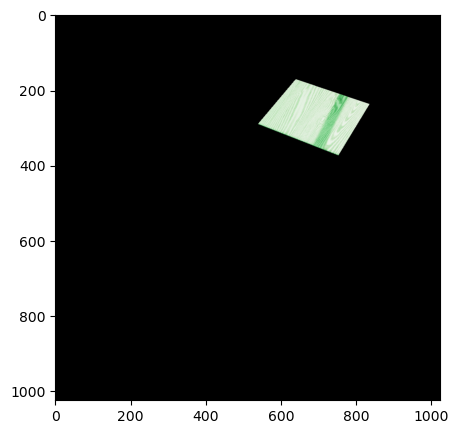

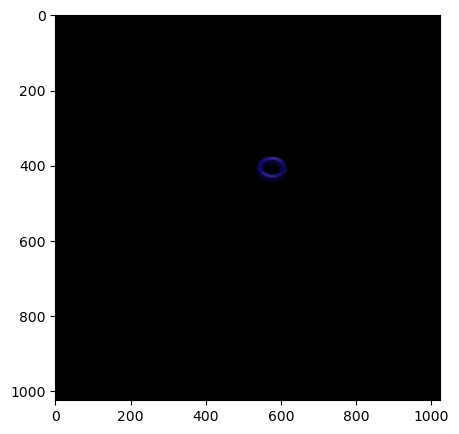

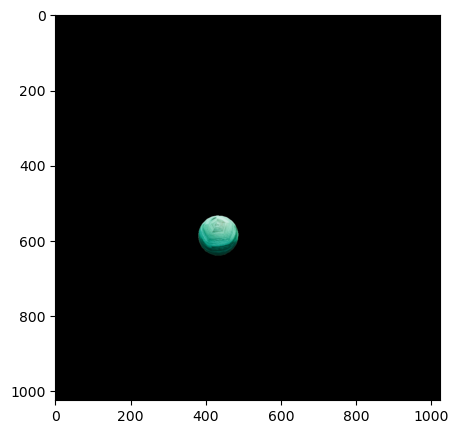

In [3]:
for (o_id, color) in zip(object_ids, object_segmentation_colors):
    area = get_mask_area(seg_arr[START_T], [color])
    print(area.shape)
    image_masked = blackout_image(rgbds[START_T], area)
    rgb_masked = image_masked[..., 0:3]
    fig = plt.figure(figsize=[5, 5])
    ax = fig.add_subplot(111)
    ax.imshow(rgb_masked)

In [17]:
rgbds = jax.image.resize(
    rgbds,
    (rgbds.shape[0], im_height, im_width, *rgbds.shape[3:]),
    method="linear",
)
im_segs = jax.image.resize(
    seg_arr,
    (seg_arr.shape[0], im_height, im_width, *seg_arr.shape[3:]),
    method="linear",
)

all_areas = []
for im_seg in im_segs:
    # all_area = im_seg != np.array([0, 0, 0])
    all_area = np.any(im_seg != np.array([0, 0, 0]), axis=-1)
    # all_area = all_area.min(-1).astype("float32")
    # all_area = all_area.reshape(
    #     (all_area.shape[-1], all_area.shape[-1])
    # ).astype(bool)
    all_areas.append(all_area)


In [18]:
all_area

Array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

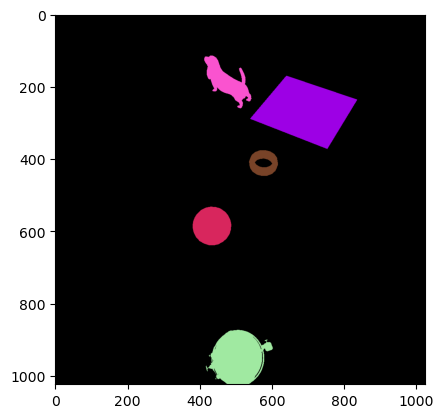

In [19]:
plt.imshow(seg_arr[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..250.00003].


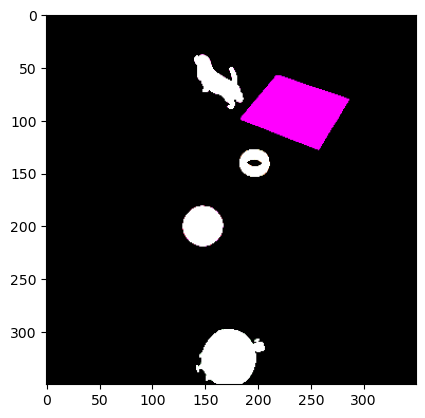

In [20]:
plt.imshow(im_segs[0])

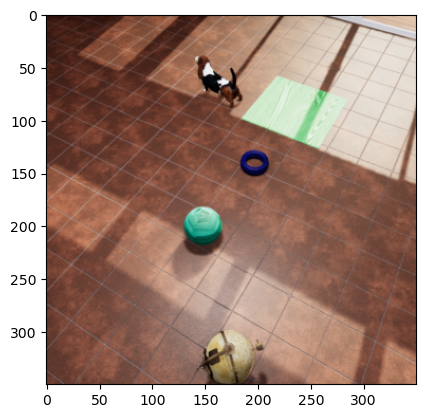

In [21]:
plt.imshow(rgbds[START_T][..., 0:3])

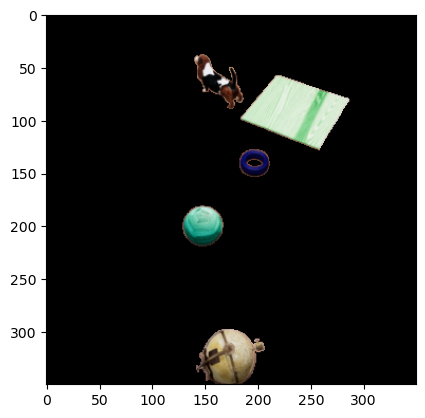

In [22]:
plt.imshow(blackout_image(rgbds[START_T][..., 0:3], all_areas[START_T]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.117852210998535].


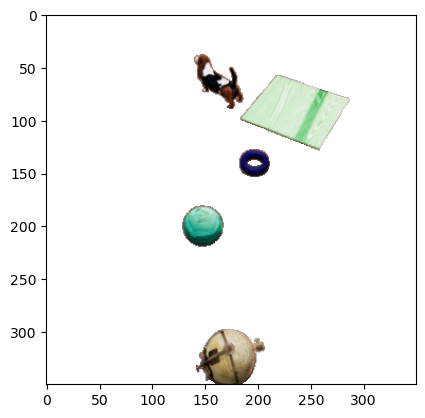

In [24]:
plt.imshow(blackout_image(rgbds[START_T], all_areas[START_T]))